In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import sys
sys.path.append('..') # to find ../utils libraries

from glob import glob
from tqdm import tqdm
from PIL import Image
import PIL

import tensorflow as tf
import scipy.misc
import numpy as np
import random

from utils import *
from hyper_picture_framework import HyperPictureFramework
import lazy_datasets

In [2]:
CELEB_PATH = '/home/jakub/Studia/mgr/ml-compression/data/img_align_celeba/test'

In [3]:
all_celebs = glob(CELEB_PATH + '/*')

In [4]:
len(all_celebs)

1999

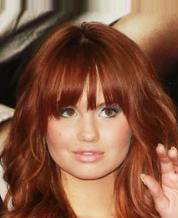

In [5]:
img = Image.open(all_celebs[0])
img

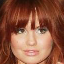

In [6]:
img = Image.open(all_celebs[0])

def img_to_np(img):
    np_img = np.array(img)
    return normalize_colors(np_img)

def normalize_colors(x):
    return x / 255.0

def celeba_crop(celeb_img, crop_size):
    crop_box = (25, 50, 25 + 2 * crop_size, 50 + 2 * crop_size)
    cropped = celeb_img.crop(crop_box)
    resized = cropped.resize((crop_size, crop_size), PIL.Image.NEAREST)
    return img_to_np(resized), resized

_, res = celeba_crop(img, 64)
res

In [13]:
BASE_PATH = '/home/jakub/Studia/mgr/ml-compression/train/miracle/saved_models/'

MODEL_NAME = 'celeba-sof-01-grad_2019_03_25__19_33_21'

CHECKPOINT_PATH = BASE_PATH + MODEL_NAME
METAGRAPH_PATH = BASE_PATH + MODEL_NAME + '/' + 'tmp-220000.meta'

QUANT_SIZE = 1.0

from tensorflow.contrib.training import HParams

hparams = HParams()

hyper_parameters = {
    'in_img_width':64,
    'in_img_height':64,
    'batch_size':16,
    'train_dataset_path':'../data/img_align_celeba/train',
    'test_dataset_path':'data/img_align_celeba/test',
    'learning_rate':7e-05,
    'steps':1000000,
    'channels':3,
    'test_per_iterations':10000,
    'decay_steps':100000,
    'decay_rate':0.92,
    'checkpoint':CHECKPOINT_PATH,
    'metagraph':METAGRAPH_PATH,
    'queue_capacity':32,
    'quant_method': 2,
    'quant_size': QUANT_SIZE,
    'resnet_type': 0,
    'max_alpha': 50.0,
    'alpha_div': 100000
}

for a,b in hyper_parameters.items():
    hparams.add_hparam(a, b)
    
from lazy_datasets import *
data_generator = Dataset(hparams)

In [17]:
saved_models_dir = None
network = HyperPictureFramework(hparams, data_generator, MODEL_NAME, saved_models_dir)

Latent: (?, 8, 8, 16)
Decoded: (?, 64, 64, 3)


In [18]:
network.restore(hparams.checkpoint, hparams.metagraph)

INFO:tensorflow:Restoring parameters from /home/jakub/Studia/mgr/ml-compression/train/miracle/saved_models/celeba-sof-01-grad_2019_03_25__19_33_21/tmp-220000


In [29]:
def test_single_image_celeb(model, img_path, batch_size, crop_size, step):
    input_image = Image.open(img_path)
    truth_image = celeba_crop(input_image, 64)

    result_image = run_through_net(model, truth_image, crop_size)
    
    ms_yuv, ps_yuv, ss_yuv, ms_rgb, ps_rgb, ss_rgb = compute_stats(truth_image, result_image, model)
    return ms_yuv, ps_yuv, ss_yuv, ms_rgb, ps_rgb, ss_rgb, (truth_image, result_image)

In [44]:
ms_yuv, ps_yuv, ss_yuv, ms_rgb, ps_rgb, ss_rgb, all_imgs = test_single_image_celeb(network, all_celebs[1110], 16, 64, 63)
truth_image, result_image = all_imgs

In [45]:
ms_rgb, ps_rgb

(0.951785, 24.060345)

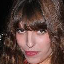

In [46]:
Image.fromarray(np.uint8((truth_image)*255))

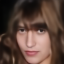

In [47]:
Image.fromarray(np.uint8((result_image)*255))